# Affine Transformations for Grayscale Images

### Import libraries

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

## Read image as numpy array

In [26]:
# Function to read and convert an image to grayscale as a numpy array
def read_grayscale(image_path):
    """
    Reads an image from the specified file path and converts it to grayscale.
    
    Args:
    image_path (str): The path to the image file to be read.
    
    Returns:
    np.ndarray: A numpy array representing the grayscale image.
    """
    # Open the image, convert it to grayscale ('L' mode), then convert to numpy array
    image = Image.open(image_path).convert("L")  # 'L' mode corresponds to grayscale
    return np.array(image)

# Function to read and convert an image to RGB as a numpy array
def read_rgb(image_path):
    """
    Reads an image from the specified file path and converts it to RGB format.
    
    Args:
    image_path (str): The path to the image file to be read.
    
    Returns:
    np.ndarray: A numpy array representing the RGB image.
    """
    # Open the image, convert it to RGB mode, then convert to numpy array
    image = Image.open(image_path).convert("RGB")  # 'RGB' mode corresponds to color image
    return np.array(image)

#--------- Load image from the specified file path ---------#

# Prompt the user to input the image file path
img_path = input("Input image path: ")

# Read the image as RGB
rgb_img = read_rgb(img_path)

# Read the image as Grayscale
grayscale_img = read_grayscale(img_path)


## Show image

In [27]:
def display_image(image, title="Image"):
    """
    Displays an image using Matplotlib.

    Args:
    image (np.ndarray or PIL.Image): The image to be displayed. This can be a numpy array 
                                     or a PIL Image object, preferably in grayscale or RGB format.
    title (str, optional): The title for the image displayed on the plot. Default is "Image".

    Returns:
    None: This function does not return any value. It simply displays the image.
    """
    # Create a figure with a specific size (6x6 inches)
    plt.figure(figsize=(6, 6))
    
    # Display the image with a grayscale colormap (if the image is grayscale)
    plt.imshow(image, cmap="gray")  # cmap='gray' is used for grayscale images
    
    # Set the title for the image plot
    plt.title(title)
    
    # Show the image plot
    plt.show()


## Affine transformation function

In [28]:
def translation_matrix(tx, ty):
    """
    Creates a translation matrix for shifting the image by (tx, ty).
    """
    return np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])

def rotation_matrix(angle, center_x, center_y):
    """
    Creates a rotation matrix for rotating the image by the given angle (in degrees) around the image center.
    """
    theta = np.radians(angle)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return np.array([
        [cos_theta, -sin_theta, (1 - cos_theta) * center_x + sin_theta * center_y],
        [sin_theta, cos_theta, (1 - cos_theta) * center_y - sin_theta * center_x],
        [0, 0, 1]
    ])

def scaling_matrix(sx, sy, center_x, center_y):
    """
    Creates a scaling matrix that scales the image by (sx, sy) around the image center.
    """
    return np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]
    ])

def flipping_matrix(dx, dy, center_x, center_y):
    """
    Creates a flipping matrix for flipping the image along the x and/or y axis,
    with respect to the center of the image.
    """
    return np.array([
        [dx, 0, (1 - dx) * center_x],  # Shift the flipped image back to the center along x-axis
        [0, dy, (1 - dy) * center_y],  # Shift the flipped image back to the center along y-axis
        [0, 0, 1]
    ])

def contrast_brightness_adjustment(img, contrast, brightness):
    """
    Adjusts the contrast and brightness of the image.
    
    If the image is grayscale (2D), it adjusts the entire image.
    If the image is RGB (3D), it adjusts each channel (R, G, B) individually.
    """
    if img.ndim == 2:
        # If the image is grayscale (2D), adjust contrast and brightness for all pixels
        return np.clip(contrast * img + brightness, 0, 255)
    elif img.ndim == 3:
        # If the image is RGB (3D), adjust contrast and brightness for each channel (R, G, B)
        # Apply to each channel individually (for R, G, B)
        img_adjusted = np.zeros_like(img, dtype=np.float32)
        for i in range(3):  # Loop over the 3 channels (Red, Green, Blue)
            img_adjusted[:, :, i] = np.clip(contrast * img[:, :, i] + brightness, 0, 255)
        return img_adjusted.astype(np.uint8)
    else:
        raise ValueError("Input image must be 2D (grayscale) or 3D (RGB)")

def affine_transform(img, matrix, output_shape):
    """
    Applies an affine transformation to an image (either grayscale or RGB) using the provided transformation matrix.

    Args:
    img (np.ndarray): The input image to which the affine transformation will be applied. 
                        Can be either a 2D (grayscale) or 3D (RGB) numpy array.
    matrix (np.ndarray): A 3x3 affine transformation matrix to be applied to the image.
    output_shape (tuple): A tuple representing the shape of the output image (height, width).

    Returns:
    np.ndarray: The transformed image of the same type as the input (grayscale or RGB).

    Raises:
    ValueError: If the input image is neither 2D (grayscale) nor 3D (RGB).
    """
    # Check the number of dimensions in the input image
    if img.ndim == 2:
        # If the image is grayscale (2D), create an empty output array of the same shape
        output_image = np.zeros(output_shape, dtype=img.dtype)
    elif img.ndim == 3:
        # If the image is RGB (3D), create an empty output array with 3 channels (RGB)
        output_image = np.zeros((output_shape[0], output_shape[1], 3), dtype=img.dtype)
    else:
        # Raise an error if the image is neither grayscale nor RGB
        raise ValueError("Input image must be 2D (grayscale) or 3D (RGB)")

    # Compute the inverse of the affine transformation matrix
    inv_matrix = np.linalg.inv(matrix)

    # Iterate over every pixel in the output image
    for i in range(output_shape[0]):
        for j in range(output_shape[1]):
            # Map the (i, j) pixel coordinates in the output image back to the input image coordinates
            src_coords = np.dot(inv_matrix, np.array([j, i, 1]))
            src_x, src_y = src_coords[:2]

            # If the source coordinates lie within the bounds of the original image, copy the pixel value
            if 0 <= src_x < img.shape[1] and 0 <= src_y < img.shape[0]:
                if img.ndim == 2:
                    # For grayscale images, directly assign the pixel value
                    output_image[i, j] = img[int(src_y), int(src_x)]
                elif img.ndim == 3:
                    # For RGB images, assign pixel values for all three channels (R, G, B)
                    output_image[i, j] = img[int(src_y), int(src_x), :]

    return output_image

def apply_transformation(img, translate=[0, 0], angle=0, scale=[1.0, 1.0], directions=[1, 1], contrast=1.0, brightness=0.0):
    """
    Applies a sequence of transformations to the image: translation, scaling, rotation, flipping,
    contrast adjustment, and brightness adjustment.
    
    Args:
        img (np.ndarray): The input image.
        translate (list): Translation values for x and y axis.
        angle (float): Rotation angle in degrees.
        scale (list): Scaling factors for x and y axis.
        directions (list): Reflection directions for x and y axis.
        contrast (float): Contrast adjustment factor.
        brightness (float): Brightness adjustment factor.
    
    Returns:
        np.ndarray: The transformed image after all operations.
    """
    # Extract transformation parameters
    tx, ty = translate
    sx, sy = scale
    dx, dy = directions

    # Determine the image center
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2

    # Step 1: Create transformation matrices for each operation
    translation = translation_matrix(tx, ty)
    rotation = rotation_matrix(angle, center_x, center_y)
    scaling = scaling_matrix(sx, sy, center_x, center_y)
    flipping = flipping_matrix(dx, dy, center_x, center_y)

    # Step 2: Combine the transformation matrices
    # Combine the translation, rotation, scaling, and flipping matrices in sequence
    matrix = translation @ rotation @ scaling @ flipping

    # Calculate the new output size based on the scale factors
    new_width = int(img.shape[1] * sx)
    new_height = int(img.shape[0] * sy)

    # Step 3: Apply affine transformation
    output_shape = (new_height, new_width)
    transformed_img = affine_transform(img, matrix, output_shape)

    # Step 4: Apply contrast and brightness adjustments
    transformed_img = contrast_brightness_adjustment(transformed_img, contrast, brightness)

    return transformed_img


## Affine transformations on grayscale image

### Translation

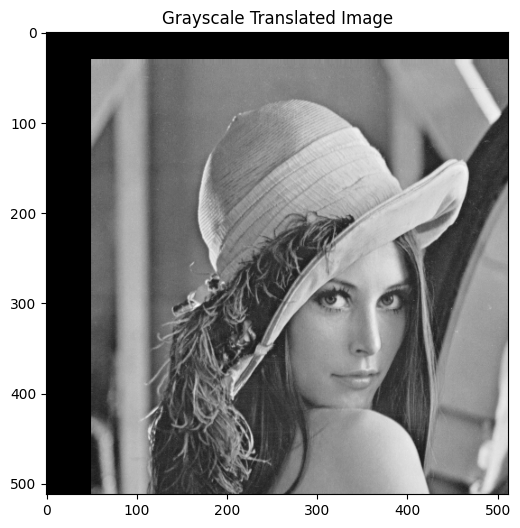

In [29]:
# Function to translate a grayscale image by given tx and ty values (horizontal and vertical translation)
def grayscale_translation(img, tx, ty):
    """
    Translates a grayscale image by the specified number of pixels in the x (horizontal) and y (vertical) directions.

    Args:
        image (np.ndarray): The input grayscale image as a 2D numpy array.
        tx (int): The number of pixels to shift the image horizontally (translation along the x-axis).
        ty (int): The number of pixels to shift the image vertically (translation along the y-axis).

    Returns:
        np.ndarray: The translated image, a numpy array of the same shape as the input image.
                    Pixels shifted outside the image boundaries are replaced with zeros (black).

    Example:
    translated_img = grayscale_translation(image, tx=50, ty=30)
    """
    # Apply the affine transformation (translation) to the image
    return apply_transformation(img, translate=[tx, ty])

# Translate the grayscale image and display the result
translated = grayscale_translation(grayscale_img, tx=50, ty=30)
display_image(translated, title="Grayscale Translated Image")


### Rotation

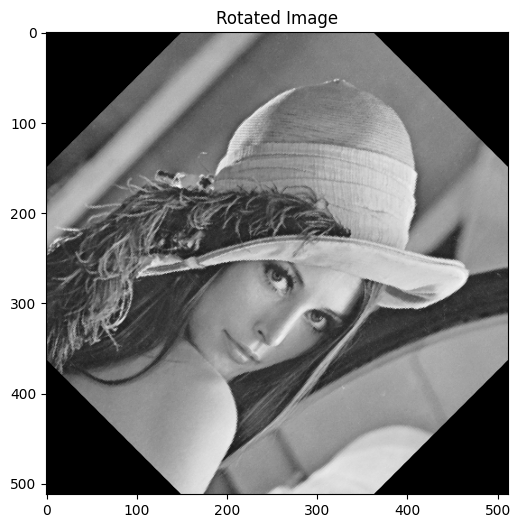

In [30]:
# Function to rotate a grayscale image by a specified angle (in degrees) around its center
def grayscale_rotation(img, angle):
    """
    Rotates a grayscale image by the specified angle around its center.

    Args:
        image (np.ndarray): The input grayscale image represented as a 2D numpy array.
        angle (float): The angle (in degrees) by which the image will be rotated counterclockwise.

    Returns:
        np.ndarray: A numpy array containing the rotated image. The output image retains the same dimensions as the input.

    Example:
        rotated_img = grayscale_rotation(image, 45)  # Rotates the image by 45 degrees.
    """
    # Apply the affine transformation (rotation) to the image
    return apply_transformation(img, angle=angle)


# Rotate the grayscale image by 45 degrees and display the result
rotated = grayscale_rotation(grayscale_img, angle=45)
display_image(rotated, title="Rotated Image")


### Scaling

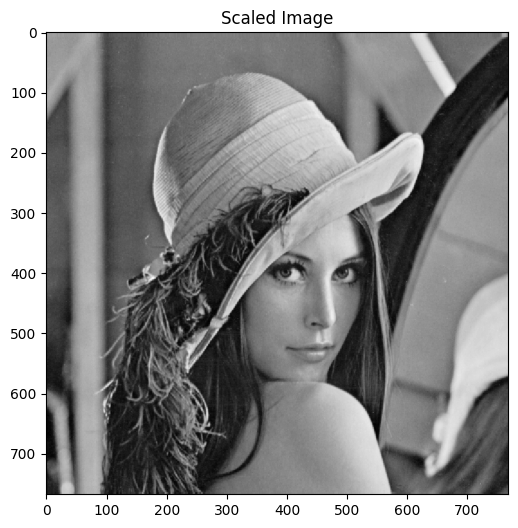

In [31]:
# Function to scale a grayscale image by specified scaling factors (sx, sy)
def grayscale_scaling(img, sx, sy):
    """
    Scales a grayscale image by the given scaling factors along the x and y axes.

    Args:
        image (np.ndarray): The input grayscale image (2D numpy array).
        sx (float): The scaling factor along the x-axis (horizontal scaling).
        sy (float): The scaling factor along the y-axis (vertical scaling).

    Returns:
        np.ndarray: The scaled image, a numpy array with the new shape.

    Example:
        scaled_img = grayscale_scaling(image, 2.0, 0.5)
    """
    # Apply the affine transformation (scaling) to the image using the scaling matrix
    return apply_transformation(img, scale=[sx, sy])


scaled = grayscale_scaling(grayscale_img, sx=1.5, sy=1.5)
display_image(scaled, title="Scaled Image")

### Reflection/Mirroring

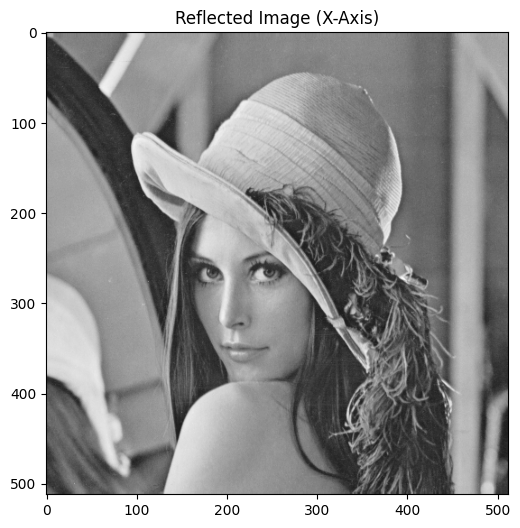

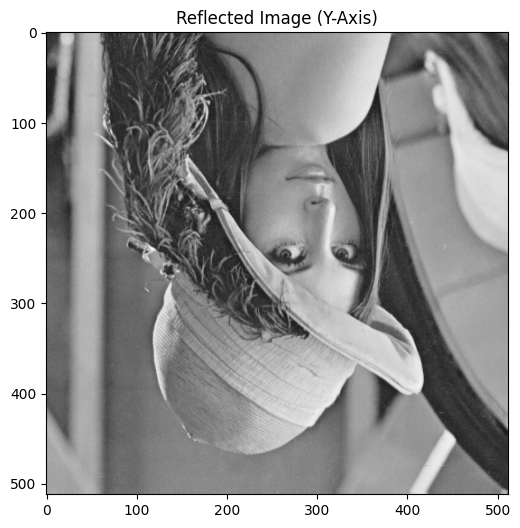

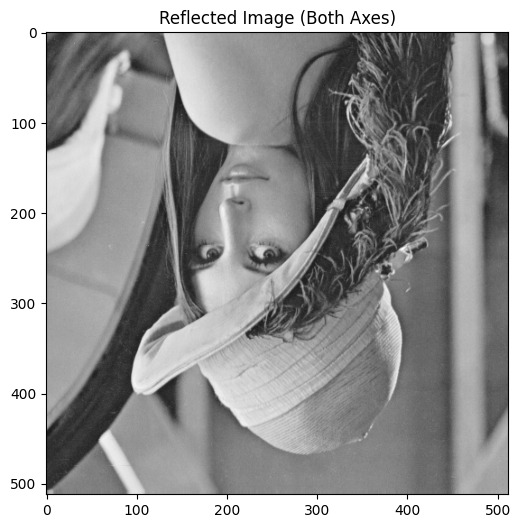

In [32]:
def grayscale_reflection(img, dx, dy):
    """
    Reflects a grayscale image across the specified axes.

    Args:
        img (np.ndarray): The input grayscale image as a 2D numpy array.
        dx (int): The reflection factor for the x-axis (horizontal).
                Use -1 for reflection along the x-axis.
        dy (int): The reflection factor for the y-axis (vertical).
                Use -1 for reflection along the y-axis.

    Returns:
        np.ndarray: The reflected image, a 2D numpy array with the same shape as the input image.

    Example:
        reflected_img = grayscale_reflection(image, dx=-1, dy=1)  # Reflect across the x-axis
    """
    
    # Apply the reflection transformation to the image using the constructed reflection matrix
    return apply_transformation(img, directions=[dx, dy])


# Example usages for reflecting along different axes
reflected_x = grayscale_reflection(grayscale_img, dx=-1, dy=1)  # Reflect along x-axis
display_image(reflected_x, title="Reflected Image (X-Axis)")

reflected_y = grayscale_reflection(grayscale_img, dx=1, dy=-1)  # Reflect along y-axis
display_image(reflected_y, title="Reflected Image (Y-Axis)")

reflected_xy = grayscale_reflection(grayscale_img, dx=-1, dy=-1)  # Reflect along both axes
display_image(reflected_xy, title="Reflected Image (Both Axes)")


## Affine transformations on RGB image

### Translation

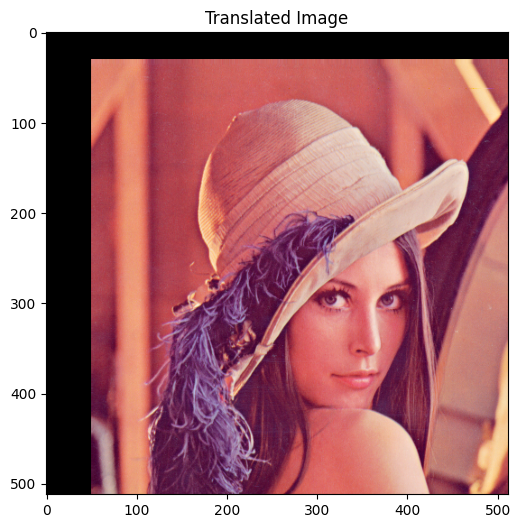

In [33]:
# Translate an RGB image by specified translation values (tx, ty)
def rgb_translation(img, tx, ty):
    """
    Translates an RGB image by the specified horizontal (tx) and vertical (ty) displacements.

    Args:
        img (np.ndarray): The input RGB image, a 3D numpy array of shape (rows, cols, 3), where each pixel
                        has three color channels (Red, Green, Blue).
        tx (int): The translation distance in the x-direction (horizontal shift). Positive values move the image right.
        ty (int): The translation distance in the y-direction (vertical shift). Positive values move the image down.

    Returns:
        np.ndarray: The translated image, a numpy array with the same shape (rows, cols, 3) as the input image,
                but with pixel positions shifted according to the translation values.

    Example:
        translated_image = rgb_translation(image, tx=50, ty=30)  # Translate the image 50 pixels to the right and 30 pixels down.
    """
    
    # Apply the translation using the constructed translation matrix
    return apply_transformation(img, translate=[tx, ty])


translated = rgb_translation(rgb_img, tx=50, ty=30)
display_image(translated, title="Translated Image")


### Rotation

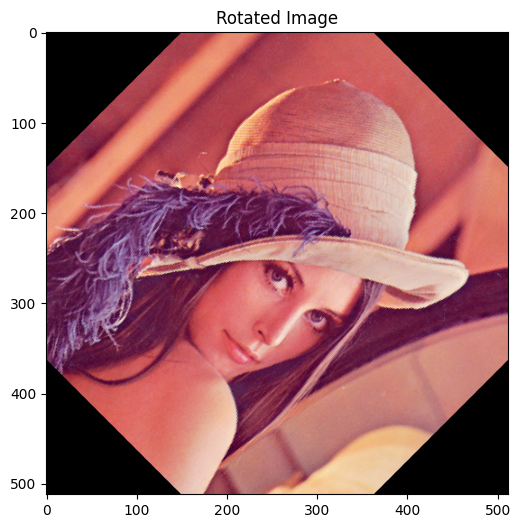

In [34]:
# Rotate an RGB image by a specified angle around its center
def rgb_rotation(img, angle):
    """
    Rotates an RGB image by the given angle in degrees around its center.

    Args:
        img (np.ndarray): The input RGB image, a 3D numpy array of shape (rows, cols, 3), 
                        where each pixel has three color channels (Red, Green, Blue).
        angle (float): The angle by which to rotate the image, in degrees. Positive values rotate counterclockwise.

    Returns:
        np.ndarray: The rotated image, a numpy array with the same shape (rows, cols, 3) as the input image,
                    but with pixel positions rotated around the center.

    Example:
        rotated_image = rgb_rotation(image, angle=45)  # Rotate the image 45 degrees counterclockwise around its center.
    """
    
    # Apply the rotation using the constructed rotation matrix
    return apply_transformation(img, angle=angle)


rotated = rgb_rotation(rgb_img, angle=45)
display_image(rotated, title="Rotated Image")


### Scaling

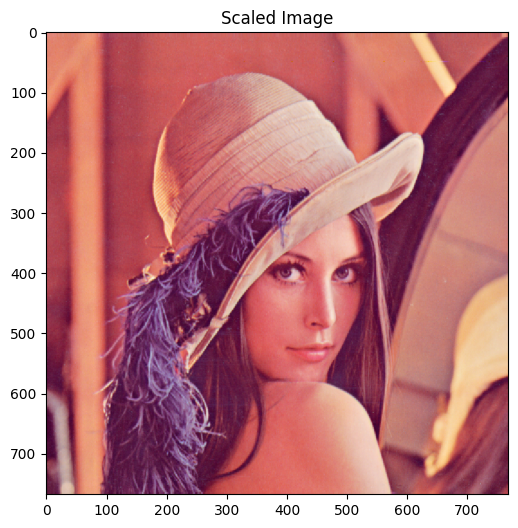

In [35]:
def rgb_scaling(img, sx, sy):
    """
    Scales an RGB image by specified factors in the x and y directions.

    Args:
        image (np.ndarray): The input RGB image, a 3D numpy array of shape (rows, cols, 3),
                            where each pixel has three color channels (Red, Green, Blue).
        sx (float): The scaling factor in the x-direction (horizontal scaling).
        sy (float): The scaling factor in the y-direction (vertical scaling).

    Returns:
        np.ndarray: The scaled image, a numpy array with the same number of channels (3), but resized
                    based on the scaling factors.

    Example:
        scaled_image = rgb_scaling(image, sx=1.5, sy=1.5)  # Scale the image by 1.5 times in both directions.
    """
    
    # Apply the scaling transformation using the scaling matrix
    return apply_transformation(img, scale=[sx, sy])


scaled = rgb_scaling(rgb_img, sx=1.5, sy=1.5)
display_image(scaled, title="Scaled Image")

### Reflection/Mirroring

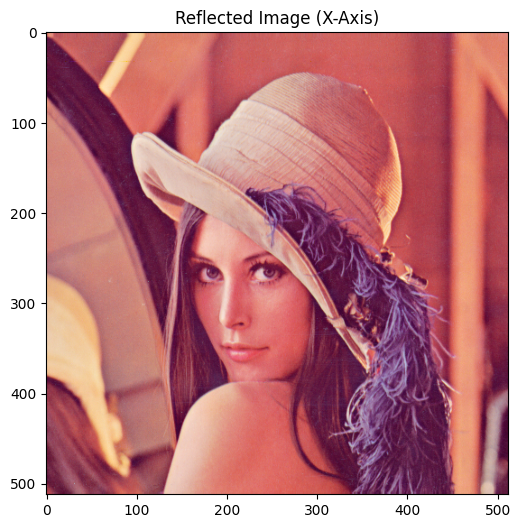

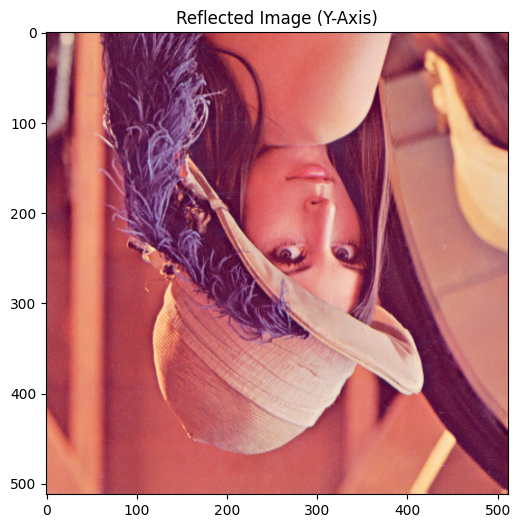

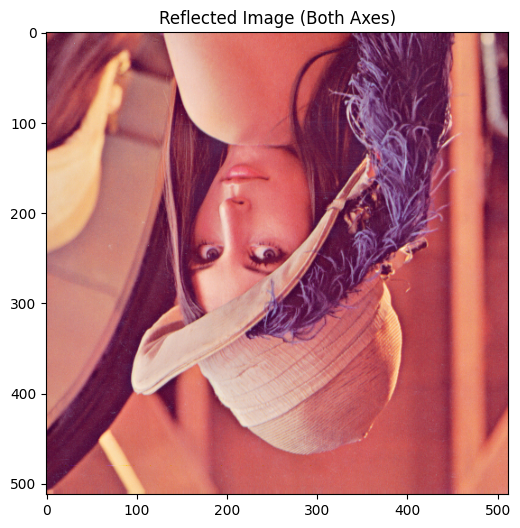

In [36]:
def rgb_reflection(image, dx, dy):
    """
    Reflects an RGB image across the specified direction (x, y, or both).

    Args:
        image (np.ndarray): The input RGB image (3D numpy array).
        dx (int): Direction for reflection along the x-axis (-1 for reflection, 1 for no reflection).
        dy (int): Direction for reflection along the y-axis (-1 for reflection, 1 for no reflection).

    Returns:
        np.ndarray: The reflected image, a numpy array with the same shape as the input image.
    
    Example:
        reflected_img = rgb_reflection(image, dx=-1, dy=1)  # Reflect across the x-axis.
    """
    
    # Apply the reflection using the transformation
    return apply_transformation(image, directions=[dx, dy])

# Example usages
reflected_x = rgb_reflection(rgb_img, dx=-1, dy=1)  # Reflect across the x-axis
display_image(reflected_x, title="Reflected Image (X-Axis)")

reflected_y = rgb_reflection(rgb_img, dx=1, dy=-1)  # Reflect across the y-axis
display_image(reflected_y, title="Reflected Image (Y-Axis)")

reflected_xy = rgb_reflection(rgb_img, dx=-1, dy=-1)  # Reflect across both axes
display_image(reflected_xy, title="Reflected Image (Both Axes)")


## Fractal image compression

In [37]:
# Parameters for transformations
directions = [1, -1]
angles = [0, 90, 180, 270]
candidates = [[direction, angle] for direction in directions for angle in angles]

### RGB image channel manipulation

In [38]:
# Manipulate channels
def extract_rgb(img):
    """
    Extracts the individual RGB channels from an RGB image.
    
    Args:
    img (np.ndarray): The input RGB image as a 3D numpy array (height, width, 3).
    
    Returns:
    tuple: Three numpy arrays representing the Red, Green, and Blue channels separately.
    
    Example:
    img_r, img_g, img_b = extract_rgb(image)
    """
    # Extract each RGB channel separately
    return img[:,:,0], img[:,:,1], img[:,:,2]


def assemble_rgb(img_r, img_g, img_b):
    """
    Assembles separate Red, Green, and Blue channels into a single RGB image.
    
    Args:
    img_r (np.ndarray): The Red channel as a 2D numpy array (height, width).
    img_g (np.ndarray): The Green channel as a 2D numpy array (height, width).
    img_b (np.ndarray): The Blue channel as a 2D numpy array (height, width).
    
    Returns:
    np.ndarray: The assembled RGB image as a 3D numpy array (height, width, 3).
    
    Notes:
    This function reshapes each channel into 3D arrays with a single channel dimension,
    and concatenates them along the third axis to form an RGB image.
    """
    # Reshape each channel to have a single channel dimension and concatenate to form an RGB image
    shape = (img_r.shape[0], img_r.shape[1], 1)
    return np.concatenate(
        (np.reshape(img_r, shape), np.reshape(img_g, shape), np.reshape(img_b, shape)), 
        axis=2
    )

In [39]:
# Function to compute contrast and brightness using a simple linear model
def find_contrast_and_brightness1(D, S):
    """
    Computes the contrast and brightness between two images using a simple linear model.
    
    The function assumes that the relationship between the source image (S) and the destination image (D)
    is of the form: D = contrast * S + brightness.
    
    Args:
    D (np.ndarray): The destination image (2D numpy array).
    S (np.ndarray): The source image (2D numpy array).
    
    Returns:
    tuple: A tuple containing two values:
        - contrast (float): The calculated contrast factor.
        - brightness (float): The calculated brightness offset.
        
    Notes:
    The contrast is fixed at 0.75, and the brightness is computed based on the difference between D and S.
    """
    contrast = 0.75  # Fixed contrast value
    brightness = (np.sum(D - contrast * S)) / D.size  # Calculate brightness as the mean difference
    return contrast, brightness  # Return the contrast and brightness values


# Function to compute contrast and brightness using a least squares approach
def find_contrast_and_brightness2(D, S):
    """
    Computes the contrast and brightness between two images using a least squares fitting method.
    
    The function models the relationship between the source image (S) and the destination image (D) as:
    D = contrast * S + brightness, and uses least squares fitting to estimate the optimal parameters.
    
    Args:
    D (np.ndarray): The destination image (2D numpy array).
    S (np.ndarray): The source image (2D numpy array).
    
    Returns:
    tuple: A tuple containing two values:
        - contrast (float): The calculated contrast factor.
        - brightness (float): The calculated brightness offset.
        
    Notes:
    This method solves for contrast and brightness using a system of linear equations derived from least squares.
    """
    # Create matrix A (with a column of ones for the intercept and a column for the source image values)
    A = np.concatenate((np.ones((S.size, 1)), np.reshape(S, (S.size, 1))), axis=1)
    
    # Reshape D to a column vector (for least squares fitting)
    b = np.reshape(D, (D.size,))
    
    # Solve the system of equations using least squares
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)  # Use lstsq for least squares fitting
    
    # x[1] is the contrast, x[0] is the brightness
    return x[1], x[0]  # Return contrast and brightness


### Grayscale image compression and decompression

In [ ]:
# Function to generate all transformed blocks of the image
# Function to generate all transformed blocks of the image
def divide_blocks(img, source_size, destination_size, step):
    """
    Generates all transformed blocks of the image for compression.
    """
    factor = source_size // destination_size  # Calculate the reduction factor
    transformed_blocks = []  # List to hold the transformed blocks
    
    # Loop through the image in steps and extract blocks
    for k in range((img.shape[0] - source_size) // step + 1):
        for l in range((img.shape[1] - source_size) // step + 1):
            # Extract a block and reduce it to destination size
            S = grayscale_scaling(img[k*step:k*step+source_size, l*step:l*step+source_size], 1/factor, 1/factor)
            
            # Apply various transformations to the block (like rotation, flipping)
            for direction, angle in candidates:
                transformed_blocks.append((k, l, direction, angle, apply_transformation(img=S, directions=directions, angle=angle)))
                
    return transformed_blocks


# Function to compress the image by selecting the best transformation for each block
def compress(img, source_size, destination_size, step):
    """
    Compresses the image by selecting the optimal transformation for each block.
    """
    transformations = []  # To store the transformations for each block
    transformed_blocks = divide_blocks(img, source_size, destination_size, step)
    i_count = img.shape[0] // destination_size  # Number of blocks along rows
    j_count = img.shape[1] // destination_size  # Number of blocks along columns
    
    # Loop through the image blocks
    for i in range(i_count):
        transformations.append([])  # Start a new row of transformations
        for j in range(j_count):
            transformations[i].append(None)  # Initialize the block's transformation
            
            min_d = float('inf')  # Initialize the minimum squared error to infinity
            D = img[i*destination_size:(i+1)*destination_size, j*destination_size:(j+1)*destination_size]
            
            # Check each transformed block and calculate the error
            for k, l, direction, angle, S in transformed_blocks:
                contrast, brightness = find_contrast_and_brightness2(D, S)  # Find contrast and brightness adjustments
                S = contrast * S + brightness  # Apply the contrast and brightness adjustments
                d = np.sum(np.square(D - S))  # Calculate squared error
                
                # If the error is smaller than the minimum, update the best transformation
                if d < min_d:
                    min_d = d
                    transformations[i][j] = (k, l, direction, angle, contrast, brightness)
    
    return transformations


# Function to decompress the image using the stored transformations
def decompress(transformations, source_size, destination_size, step, nb_iter=10):
    """
    Decompresses the image by applying the stored transformations iteratively.
    """
    factor = source_size // destination_size  # Calculate the reduction factor
    height = len(transformations) * destination_size  # Calculate the height of the output image
    width = len(transformations[0]) * destination_size  # Calculate the width of the output image
    iterations = [np.random.randint(0, 256, (height, width))]  # Initialize with a random image
    cur_img = np.zeros((height, width))  # Current image (initially blank)
    
    # Iterate through the process for a specified number of iterations
    for i_iter in range(nb_iter):
        for i in range(len(transformations)):
            for j in range(len(transformations[i])):
                k, l, flip, angle, contrast, brightness = transformations[i][j]
                
                # Extract and reduce the corresponding block
                S = grayscale_scaling(iterations[-1][k*step:k*step+source_size, l*step:l*step+source_size], 1/factor, 1/factor)
                
                # Ensure 'flip' is a list/tuple, passing [flip_x, flip_y]
                flip_x, flip_y = flip, flip  # Here you could modify how flip is handled if needed
                
                # Apply the transformation (flip, angle, contrast, brightness)
                D = apply_transformation(S, directions=[flip_x, flip_y], angle=angle, contrast=contrast, brightness=brightness)
                
                # Place the transformed block in the correct position in the current image
                cur_img[i*destination_size:(i+1)*destination_size, j*destination_size:(j+1)*destination_size] = D
        
        iterations.append(cur_img)  # Add the current image to the iteration history
        cur_img = np.zeros((height, width))  # Reset the current image for the next iteration
    
    return iterations  # Return the sequence of reconstructed images from each iteration


### RGB image compression and decompression

In [41]:
# Function to compress an RGB image by applying compression to each color channel
def compress_rgb(img, source_size, destination_size, step):
    """
    Compresses an RGB image by applying the block-based compression algorithm to each color channel.

    This function splits the RGB image into its red, green, and blue channels and then applies 
    the `compress` function to each channel independently. The compression of each channel involves 
    dividing the image into smaller blocks, applying transformations, and storing the best transformation 
    for each block.
    
    Args:
    img (np.ndarray): The input RGB image (3D numpy array).
    source_size (int): The size of the source block.
    destination_size (int): The size of the destination (compressed) block.
    step (int): The step size to move the sliding window across the image.
    
    Returns:
    list: A list containing the compressed transformations for each channel [red, green, blue].
    """
    # Extract RGB channels from the image
    img_r, img_g, img_b = extract_rgb(img)
    
    # Apply the compression function to each channel separately
    return [compress(img_r, source_size, destination_size, step), 
            compress(img_g, source_size, destination_size, step), 
            compress(img_b, source_size, destination_size, step)]


# Function to decompress an RGB image by applying decompression to each color channel
def decompress_rgb(transformations, source_size, destination_size, step, nb_iter=8):
    """
    Decompresses an RGB image by applying the stored transformations to each color channel.

    This function reconstructs each color channel (red, green, and blue) independently by applying 
    the decompression process to the transformations stored during compression. The final RGB image 
    is then assembled by combining the decompressed channels.
    
    Args:
    transformations (list): A list containing the stored transformations for each color channel 
                             [red, green, blue].
    source_size (int): The size of the source block.
    destination_size (int): The size of the destination (compressed) block.
    step (int): The step size to move the sliding window across the image.
    nb_iter (int, optional): The number of iterations to refine the decompression. Default is 8.
    
    Returns:
    np.ndarray: The decompressed RGB image (3D numpy array).
    """
    # Decompress each color channel independently using the stored transformations
    img_r = decompress(transformations[0], source_size, destination_size, step, nb_iter)[-1]
    img_g = decompress(transformations[1], source_size, destination_size, step, nb_iter)[-1]
    img_b = decompress(transformations[2], source_size, destination_size, step, nb_iter)[-1]
    
    # Reassemble the RGB channels into a single color image
    return assemble_rgb(img_r, img_g, img_b)


### Display image in each iteration

In [42]:
def plot_iterations(iterations, target=None):
    """
    Plots a series of images (iterations) in a grid layout, with an optional target image to calculate the error between each image and the target.

    Args:
    iterations (list of np.ndarray): A list of images to be plotted, where each image is represented as a 2D numpy array.
    target (np.ndarray, optional): The target image to compare each iteration against. If provided, the title of each subplot will display the Root Mean Square Error (RMSE) between the iteration and the target.

    Returns:
    None
    
    Notes:
    - The images are displayed in a grid, where the number of rows and columns are determined dynamically based on the total number of iterations.
    - If a target image is provided, the RMSE between each iteration and the target is displayed as part of the title for each subplot.
    - The `vmin` and `vmax` parameters of `imshow` are set to scale the images to the 0-255 range, assuming grayscale images.
    """
    # Create a new figure to display the images
    plt.figure(figsize=(10, 10))
    
    # Calculate the number of rows and columns for the subplot grid
    nb_row = math.ceil(np.sqrt(len(iterations)))  # Use square root to create a roughly square grid
    nb_cols = nb_row  # Set the number of columns equal to the number of rows
    
    # Loop over the iterations (images) and plot them
    for i, img in enumerate(iterations):
        # Create a subplot for each image in the grid
        plt.subplot(nb_row, nb_cols, i+1)
        
        # Display the image in grayscale
        plt.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
        
        # If a target image is provided, display the RMSE in the title
        if target is None:
            plt.title(str(i))  # Use the index as the title
        else:
            # Calculate the Root Mean Square Error (RMSE) between the current image and the target
            rmse = np.sqrt(np.mean(np.square(target - img)))  # RMSE calculation
            plt.title(f"{i} ({rmse:.2f})")  # Display RMSE in the title
        
        # Hide the x and y axis ticks for a cleaner display
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)
    
    # Adjust layout to prevent overlap of subplots
    plt.tight_layout()


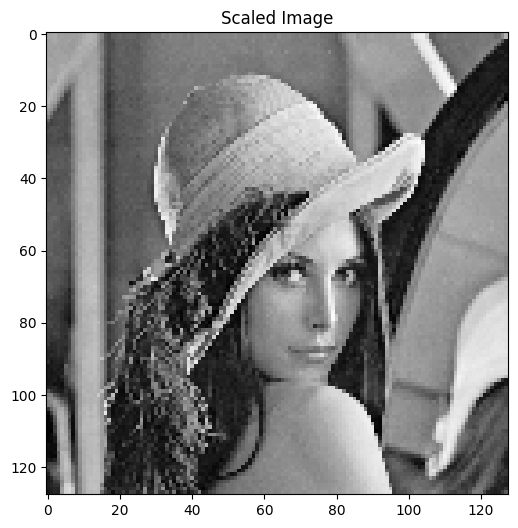

0/32 ; 0/32
0/32 ; 1/32
0/32 ; 2/32
0/32 ; 3/32
0/32 ; 4/32
0/32 ; 5/32
0/32 ; 6/32
0/32 ; 7/32
0/32 ; 8/32
0/32 ; 9/32
0/32 ; 10/32
0/32 ; 11/32
0/32 ; 12/32
0/32 ; 13/32
0/32 ; 14/32
0/32 ; 15/32
0/32 ; 16/32
0/32 ; 17/32
0/32 ; 18/32
0/32 ; 19/32
0/32 ; 20/32
0/32 ; 21/32
0/32 ; 22/32
0/32 ; 23/32
0/32 ; 24/32
0/32 ; 25/32
0/32 ; 26/32
0/32 ; 27/32
0/32 ; 28/32
0/32 ; 29/32
0/32 ; 30/32
0/32 ; 31/32
1/32 ; 0/32
1/32 ; 1/32
1/32 ; 2/32
1/32 ; 3/32
1/32 ; 4/32
1/32 ; 5/32
1/32 ; 6/32
1/32 ; 7/32
1/32 ; 8/32
1/32 ; 9/32
1/32 ; 10/32
1/32 ; 11/32
1/32 ; 12/32
1/32 ; 13/32
1/32 ; 14/32
1/32 ; 15/32
1/32 ; 16/32
1/32 ; 17/32
1/32 ; 18/32
1/32 ; 19/32
1/32 ; 20/32
1/32 ; 21/32
1/32 ; 22/32
1/32 ; 23/32
1/32 ; 24/32
1/32 ; 25/32
1/32 ; 26/32
1/32 ; 27/32
1/32 ; 28/32
1/32 ; 29/32
1/32 ; 30/32
1/32 ; 31/32
2/32 ; 0/32
2/32 ; 1/32
2/32 ; 2/32
2/32 ; 3/32
2/32 ; 4/32
2/32 ; 5/32
2/32 ; 6/32
2/32 ; 7/32
2/32 ; 8/32
2/32 ; 9/32
2/32 ; 10/32
2/32 ; 11/32
2/32 ; 12/32
2/32 ; 13/32
2/32 ; 14/32
2/3

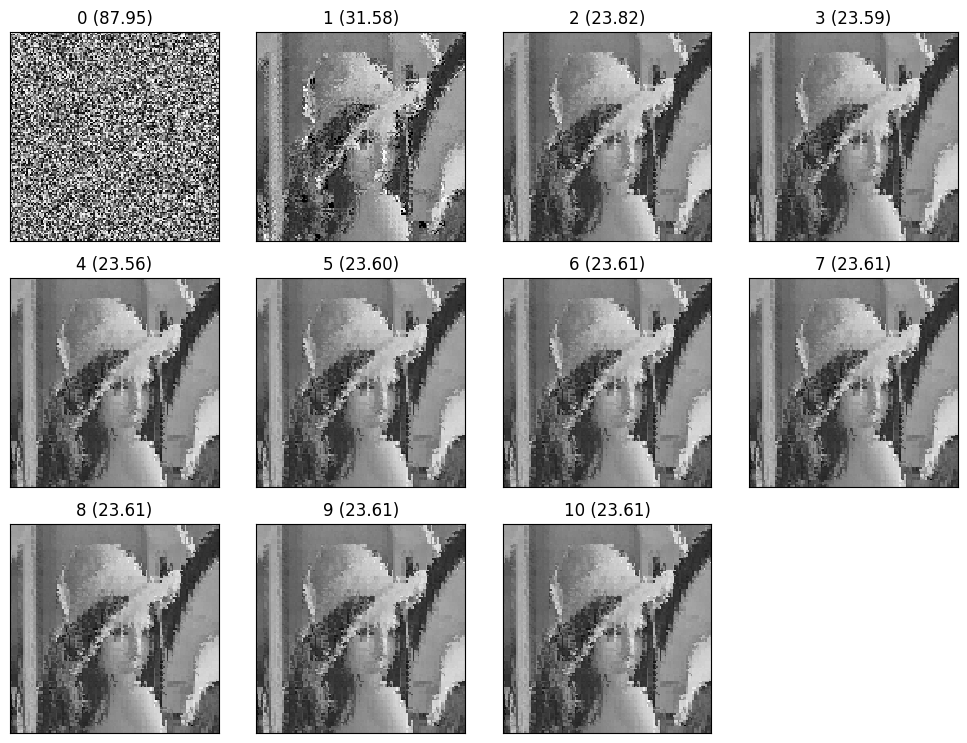

In [43]:
# Test grayscale
def test_greyscale(img):
    scaled_img = grayscale_scaling(img, 1/4, 1/4)
    display_image(scaled_img, "Scaled Image")
    transformations = compress(scaled_img, 8, 4, 8)
    iterations = decompress(transformations, 8, 4, 8)
    plot_iterations(iterations, scaled_img)
    plt.show()

test_greyscale(grayscale_img)

0/16 ; 0/16
0/16 ; 1/16
0/16 ; 2/16
0/16 ; 3/16
0/16 ; 4/16
0/16 ; 5/16
0/16 ; 6/16
0/16 ; 7/16
0/16 ; 8/16
0/16 ; 9/16
0/16 ; 10/16
0/16 ; 11/16
0/16 ; 12/16
0/16 ; 13/16
0/16 ; 14/16
0/16 ; 15/16
1/16 ; 0/16
1/16 ; 1/16
1/16 ; 2/16
1/16 ; 3/16
1/16 ; 4/16
1/16 ; 5/16
1/16 ; 6/16
1/16 ; 7/16
1/16 ; 8/16
1/16 ; 9/16
1/16 ; 10/16
1/16 ; 11/16
1/16 ; 12/16
1/16 ; 13/16
1/16 ; 14/16
1/16 ; 15/16
2/16 ; 0/16
2/16 ; 1/16
2/16 ; 2/16
2/16 ; 3/16
2/16 ; 4/16
2/16 ; 5/16
2/16 ; 6/16
2/16 ; 7/16
2/16 ; 8/16
2/16 ; 9/16
2/16 ; 10/16
2/16 ; 11/16
2/16 ; 12/16
2/16 ; 13/16
2/16 ; 14/16
2/16 ; 15/16
3/16 ; 0/16
3/16 ; 1/16
3/16 ; 2/16
3/16 ; 3/16
3/16 ; 4/16
3/16 ; 5/16
3/16 ; 6/16
3/16 ; 7/16
3/16 ; 8/16
3/16 ; 9/16
3/16 ; 10/16
3/16 ; 11/16
3/16 ; 12/16
3/16 ; 13/16
3/16 ; 14/16
3/16 ; 15/16
4/16 ; 0/16
4/16 ; 1/16
4/16 ; 2/16
4/16 ; 3/16
4/16 ; 4/16
4/16 ; 5/16
4/16 ; 6/16
4/16 ; 7/16
4/16 ; 8/16
4/16 ; 9/16
4/16 ; 10/16
4/16 ; 11/16
4/16 ; 12/16
4/16 ; 13/16
4/16 ; 14/16
4/16 ; 15/16
5/16 ; 0/1

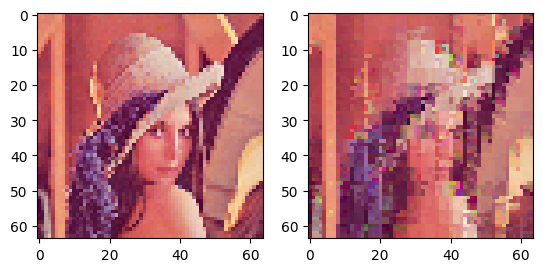

In [44]:
# Test color
def test_rgb(img):
    scaled_img = rgb_scaling(img, 1/8, 1/8)
    transformations = compress_rgb(scaled_img, 8, 4, 8)
    retrieved_img = decompress_rgb(transformations, 8, 4, 8)
    plt.figure()
    plt.subplot(121)
    plt.imshow(np.array(scaled_img).astype(np.uint8), interpolation='none')
    plt.subplot(122)
    plt.imshow(retrieved_img.astype(np.uint8), interpolation='none')
    plt.show()

test_rgb(rgb_img)